In [11]:
import sys,os
#import setGPU
import numpy as np
import h5py
import random

import sklearn
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import random

#sys.path.append(os.path.abspath(os.path.join('../ADgvae/')))
from pathlib import Path
from importlib import reload  
import os.path as osp
#sys.path.append(os.path.abspath(os.path.join('../../minisom/')))
#reload(minisom)
#from minisom import MiniSom

sys.path.append(os.path.abspath(os.path.join('../IDEC/')))
import data_utils.data_processing as data_proc
reload(data_proc)
from data_utils.data_processing import GraphDataset, DenseEventDataset
from training_utils.metrics import cluster_acc
from models.models import GraphAE, IDEC 
from training_utils.training import target_distribution,pretrain_ae_graph, train_test_ae_graph,train_test_idec_graph
from training_utils.activation_funcs  import get_activation_func

import torch
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data, Batch, DataLoader
from data_utils.data_processing import GraphDataset,DenseEventDataset
from training_utils.metrics import cluster_acc

from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

import matplotlib.colors as colors
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

from sklearn.manifold import TSNE

import matplotlib.colors as colors

sys.path.append(os.path.abspath(os.path.join('../')))

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [13]:
firon='' #
DATA_PATH='/eos/user/n/nchernya/MLHEP/AnomalyDetection/autoencoder_for_anomaly/graph_AD_event_based/'+firon+'/run_18/evaluated/'
BG_NAME = 'background_evaluated_model51_0.h5'
SIG_NAME = 'signals_evaluated_model51_0.h5'
bg_file = h5py.File(DATA_PATH+BG_NAME,'r')
sig_file = h5py.File(DATA_PATH+SIG_NAME,'r')

In [14]:
bg_dict = {}
sig_dict = {}
loss_names = []
for k in list(bg_file.keys()):
    for f,d in zip([bg_file,sig_file],[bg_dict,sig_dict]):
        d[k] = np.array(f[k],dtype=np.float16)
    if 'loss' in k: 
        loss_names.append(k)

In [15]:
bg_dict['ProcessID'].shape

(9984, 1)

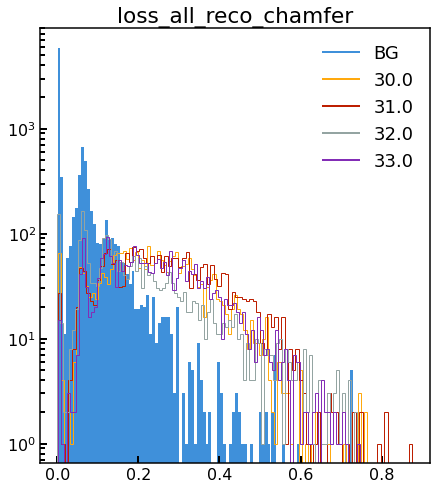

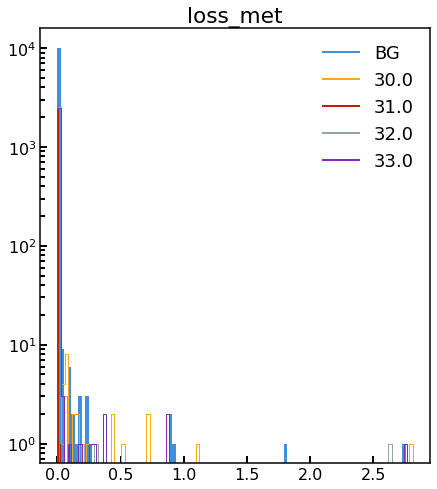

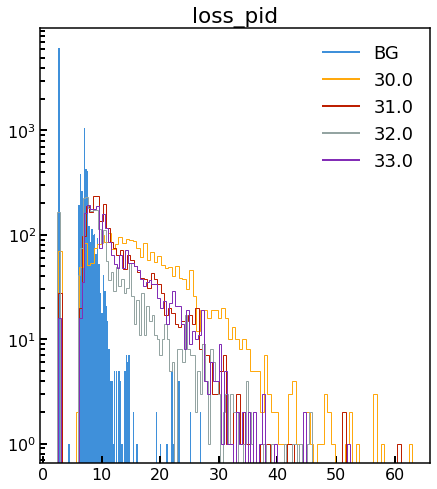

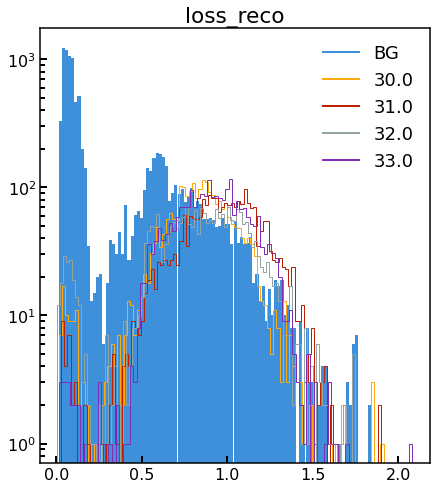

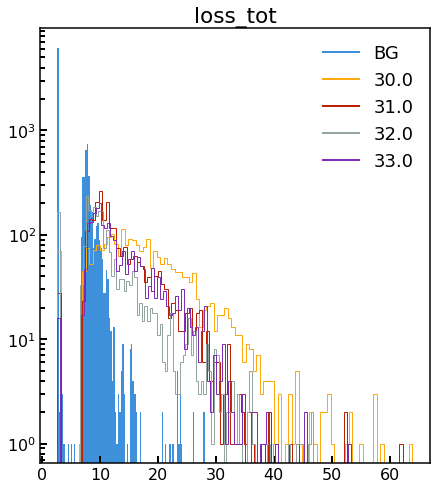

In [16]:
from matplotlib.lines import Line2D
import matplotlib

def legend_w_lines(ax):
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    for h in handles:
        if type(h)==matplotlib.patches.Rectangle:
            c = h.get_facecolor()
        else :
            c = h.get_edgecolor()
        new_handles.append(Line2D([], [], c=c))
    ax.legend(handles=new_handles, labels=labels)

plt_evt = int(1e5)
for loss in loss_names:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    _ = ax.hist(bg_dict[loss][:plt_evt],bins=100,label='BG')
    for sig in np.unique(sig_dict['ProcessID'][:,0]):
        _ = plt.hist(sig_dict[loss][sig_dict['ProcessID'][:,0]==sig][:plt_evt],bins=100,histtype='step',label=sig)
    plt.title(loss)
    legend_w_lines(ax)

    plt.semilogy()

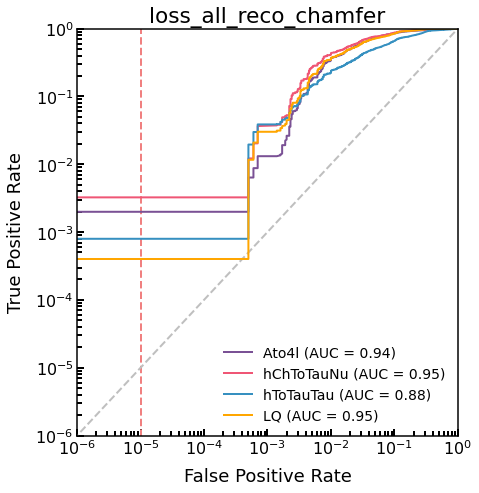

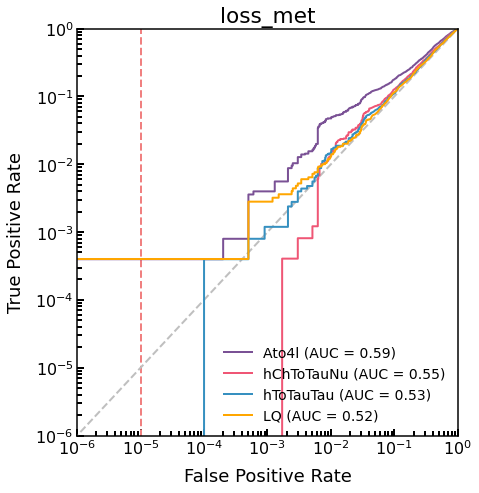

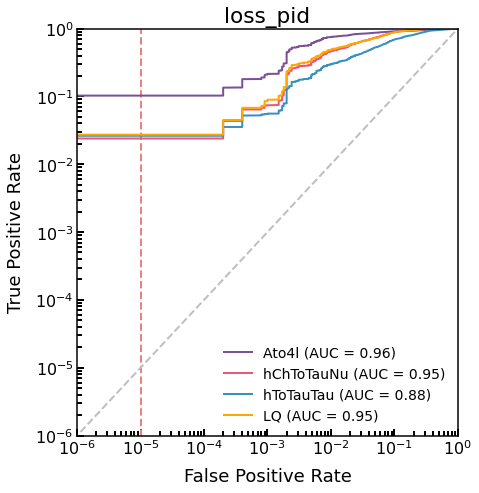

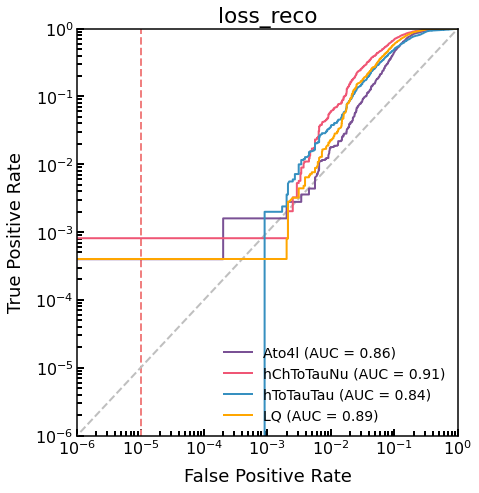

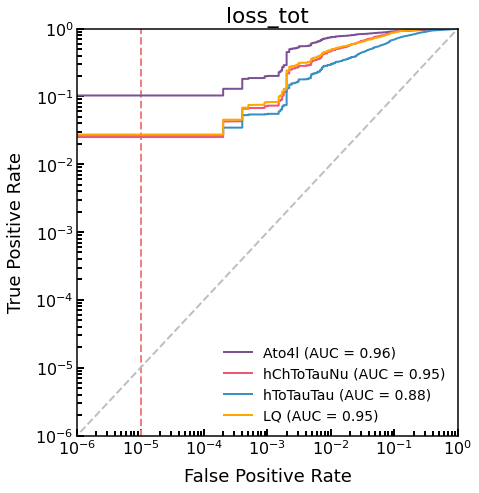

In [17]:
import plotting_utils.util_plotting as util_plt

SIG_NAMES = [data_proc.process_name_dict[s_id] for s_id in np.unique(sig_dict['ProcessID'][:,0])]
for loss in loss_names:
    neg_class_losses,pos_class_losses = util_plt.prepare_neg_pos_losses(bg_dict[loss],sig_dict[loss],sig_dict['ProcessID'])
    util_plt.plot_roc(neg_class_losses, pos_class_losses, legend=SIG_NAMES, title=loss,
            plot_name='test',xlim=1e-6,ylim=1e-6, fig_dir=None,log_x=True ,legend_loc='lower right')
    plt.show()

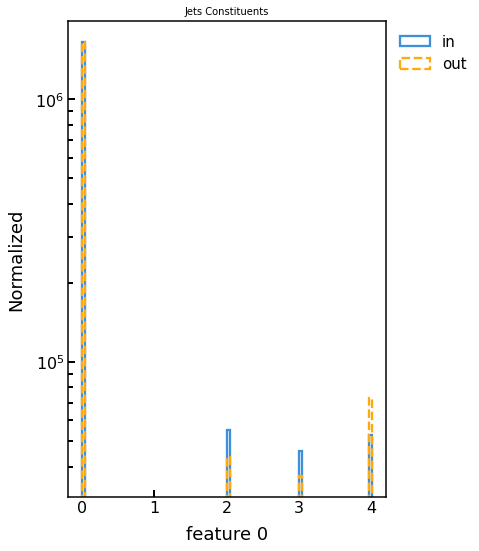

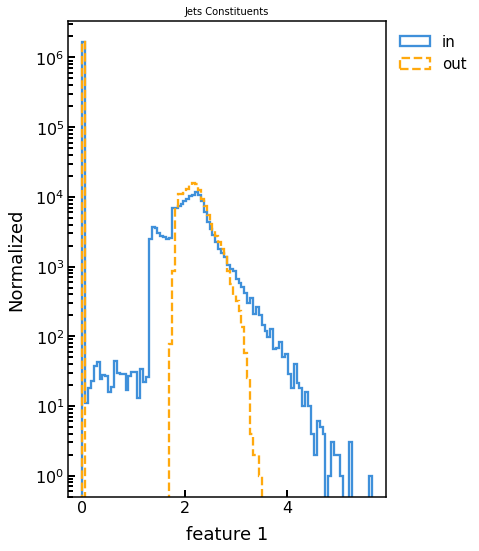

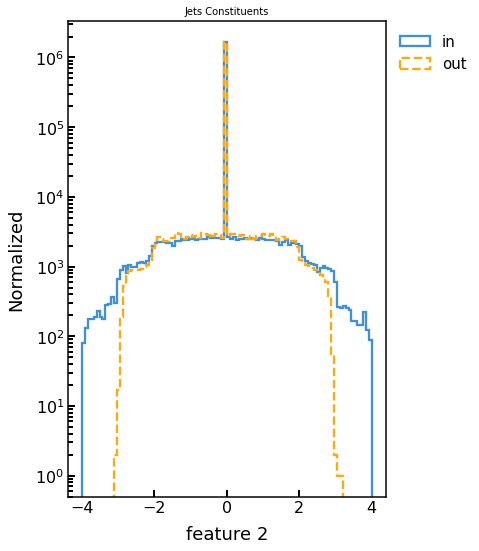

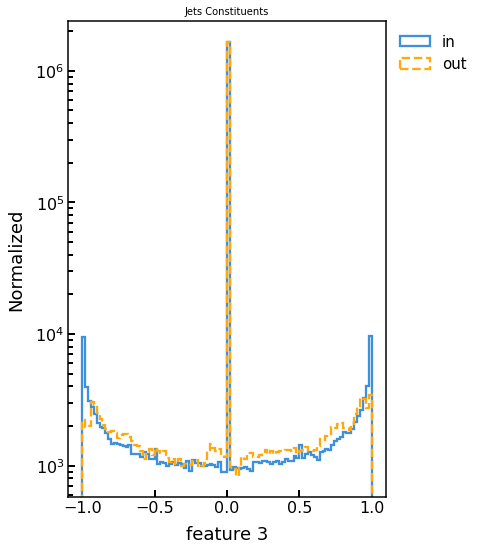

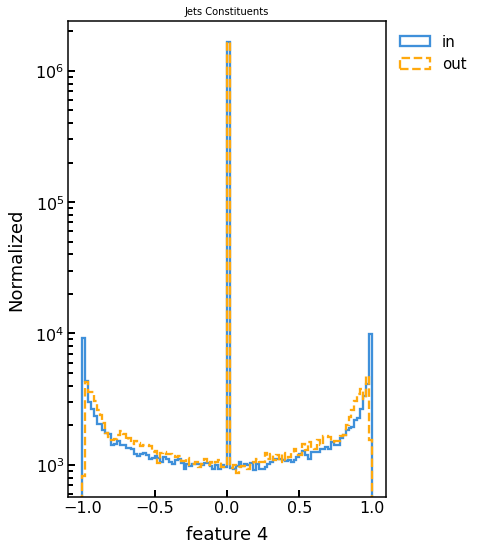

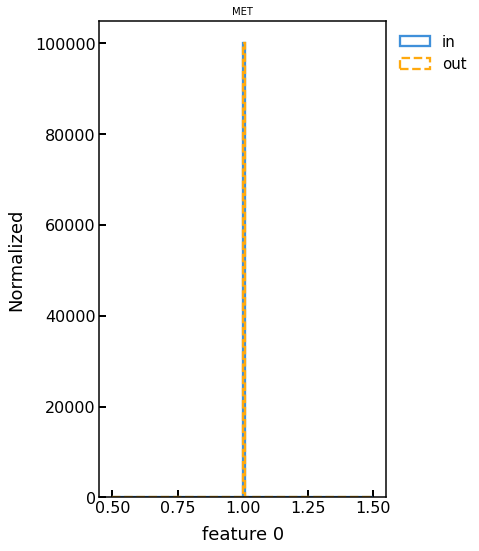

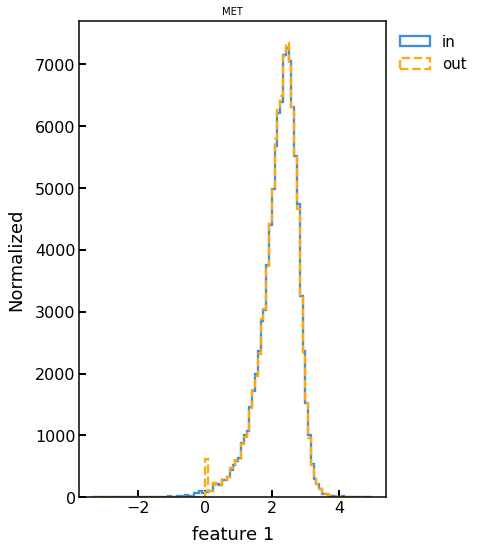

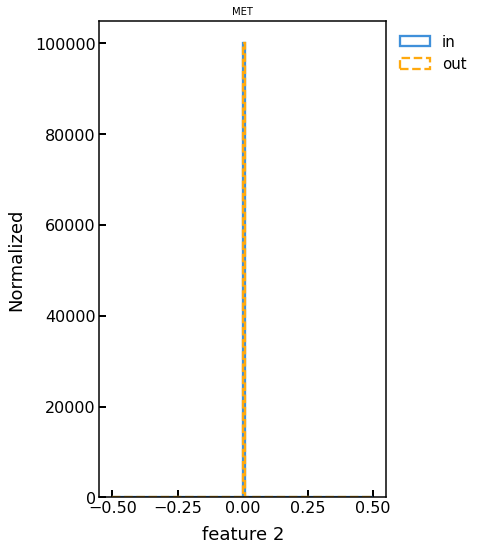

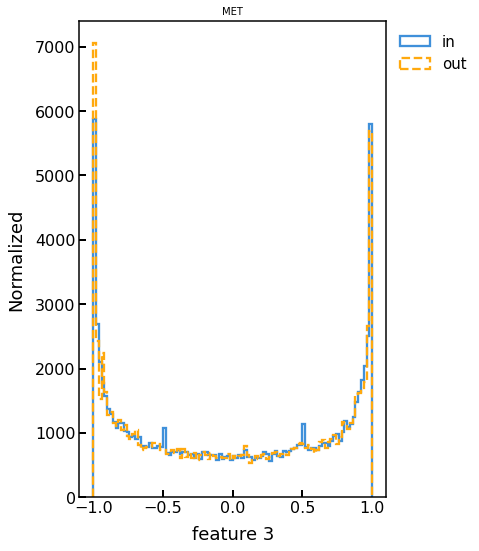

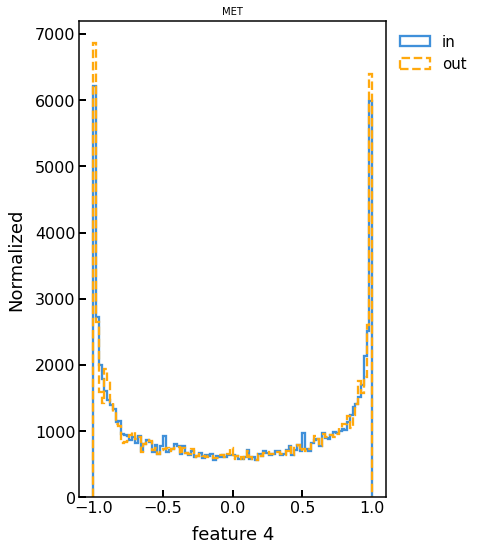

In [9]:
import plotting_utils.util_plotting as util_plt
reload(util_plt)

def reshape_3d_to_2d(ar):
    return ar.reshape((-1,ar.shape[2]))
    

util_plt.plot_features([reshape_3d_to_2d(bg_dict['InputParticles'][:plt_evt,1:,:]),reshape_3d_to_2d(bg_dict['PredictedParticles'][:plt_evt,1:,:])], 'feature' ,
                             'Normalized' , 'Jets Constituents', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=True)
    
util_plt.plot_features([reshape_3d_to_2d(bg_dict['InputParticles'][:plt_evt,0:1,:]),reshape_3d_to_2d(bg_dict['PredictedParticles'][:plt_evt,0:1,:])], 'feature' ,
                             'Normalized' , 'MET', 
                             plotname='test',
                             legend=['in','out'],
                              ylogscale=False)

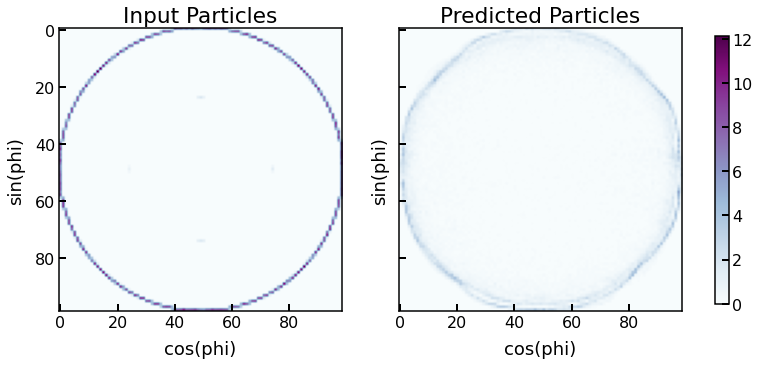

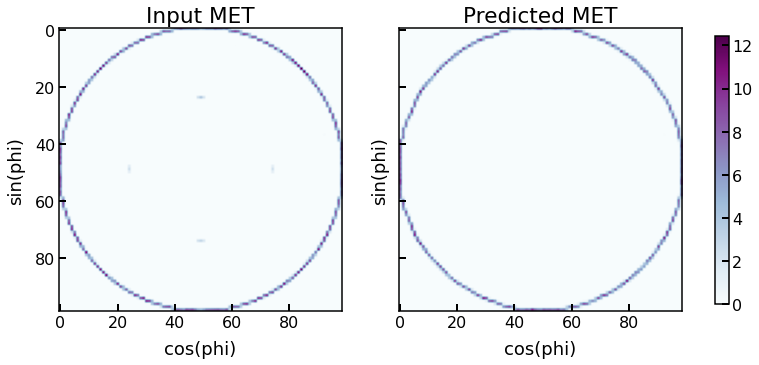

In [10]:
inp_phi = reshape_3d_to_2d(bg_dict['InputParticles'][:plt_evt,1:,[0,-2,-1]])
inp_phi = inp_phi[inp_phi[:,0]!=0][:,1:]
pred_phi = reshape_3d_to_2d(bg_dict['PredictedParticles'][:plt_evt,1:,[0,-2,-1]])
pred_phi = pred_phi[pred_phi[:,0]!=0][:,1:]
util_plt.plot_phi_correlations(inp_phi,pred_phi,title='Particles')

util_plt.plot_phi_correlations(reshape_3d_to_2d(bg_dict['InputParticles'][:plt_evt,0:1,[-2,-1]]),\
                      reshape_3d_to_2d(bg_dict['PredictedParticles'][:plt_evt,0:1,[-2,-1]]),\
                     title='MET')